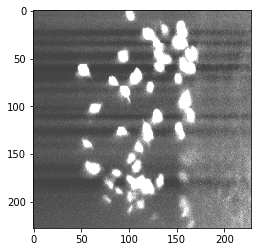

In [296]:
import tifffile
import matplotlib.pyplot as plt
plt.gray()

input_path = 'crop.tif'

input_img = tifffile.imread(input_path)

plt.imshow(input_img, clim=[0, 400])
plt.show()

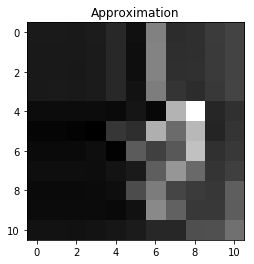

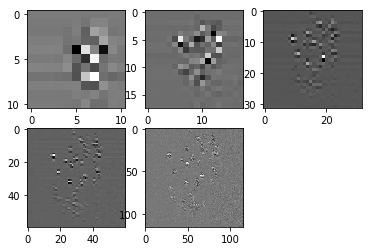

In [297]:
import pywt
import numpy as np

wavelet = 'db3'

coeffs = pywt.wavedec2(input_img, wavelet)
approx = coeffs[0]
detail = coeffs[1:]

nb_levels = len(detail)

plt.title('Approximation')
plt.imshow(approx)
plt.show()

for i, (ch, cv, cd) in enumerate(detail):
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch)
plt.show()

The streak energy is contained within the horizontal coefficients along with "true" signal from the cell bodies. If there were no cell bodies, the streaks would be constant horizontally, allowing us to take a horizontal FFT to collapse the energy to a delta function for easy filtering. In the presence of cell bodies, the parts of the streaks near the cell bodies will not be filtered out this way because there is high frequency information (a strong vertical edge).


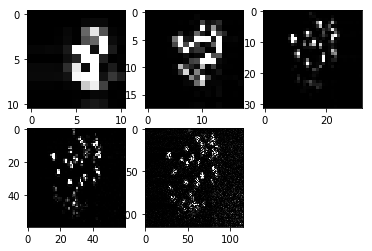

In [298]:
for i, (ch, cv, cd) in enumerate(detail):
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    ch_sq = ch**2
    plt.imshow(ch_sq, clim=[0, ch_sq.max()/10])
plt.show()

It looks like the cell body energy is ~10x stronger than the streak energy, so we might be able to use a dual-band approach that explots this. We can clip the horizontal components at a fixed, low energy level, filter the low-energy image, and then add back in the unfiltered high-energy image. Since the coefficients are floating point, we need to use the square for finding our energy level segmentation. If we need to smooth this interface, we can gaussian smooth the mask and use that in a homotopy between the filtered and unfiltered images

max energy on level 5: 92269811.34534775
max energy on level 4: 230594974.425159
max energy on level 3: 190203936.75985393
max energy on level 2: 24233793.391014863
max energy on level 1: 4780063.809309247


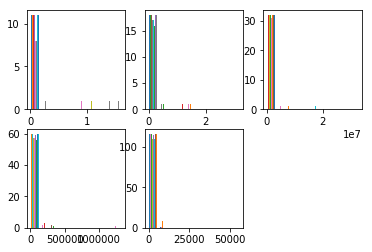

In [299]:
for i, (ch, cv, cd) in enumerate(detail):
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    ch_sq = ch**2
    plt.hist(ch_sq[:])
    print(f'max energy on level {nb_levels-i}: {ch_sq.sum()}')
plt.show()

# High-pass FFT filtering

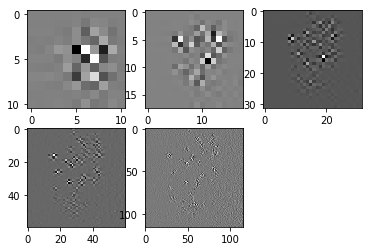

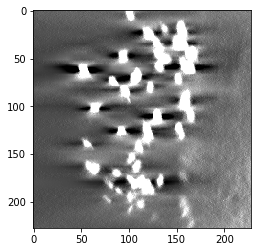

In [300]:
from scipy import fftpack
from pystripe import gaussian_filter

sigma = 64  # pixels

width_fraction = sigma / input_img.shape[0]

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    ch_fft = fftpack.rfft(ch, axis=-1)
    
    s = ch.shape[0] * width_fraction
    g = gaussian_filter(shape=ch_fft.shape, sigma=s)
    
    ch_filtered = fftpack.irfft(ch_fft * g)
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch_filtered)
    
    coeff_filtered.append((ch_filtered, cv, cd))

plt.show()
    
img_filtered = pywt.waverec2(coeff_filtered, wavelet)

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

Removing the low-frequency information after a horizontal FFT causes significant ringing because of the cell bodies

# Energy thresholding

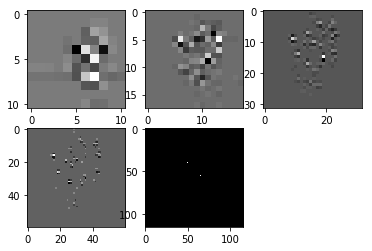

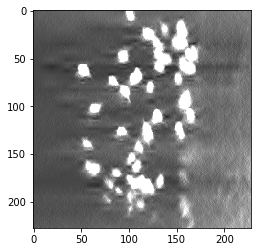

In [301]:
from skimage import filters

threshold = 50000

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    mask = ch**2 > threshold
    ch_filtered = ch * mask
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch_filtered)
    
    coeff_filtered.append((ch_filtered, cv, cd))

plt.show()
    
img_filtered = pywt.waverec2(coeff_filtered, wavelet)

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

Thresholding the horizontal coefficient energy seems to work better. However, some artifacts still remain.

A better approach would be to threshold out high energy regions (cell bodies) to isolate the streaks within the background. Then, we can fill in the missing regions in the background images with the mean of values in the same row (to try to make it look more like a 'streak')

# Combined thresholding-FFT filtering

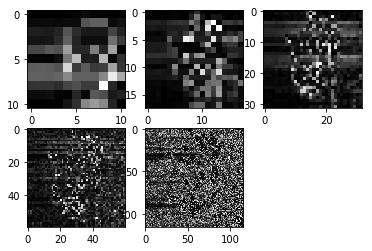

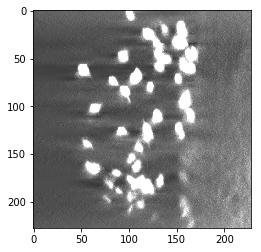

In [302]:
max_threshold = 1000
sigma = 32

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    ch_sq = ch**2
    ch_power = np.sqrt(ch_sq)
    threshold = min(max_threshold, filters.threshold_li(ch_power))
    
    mask = ch_power > threshold
    foreground = ch * mask
    background = ch * (1-mask)
    
    background_means = np.broadcast_to(np.mean(background, axis=-1)[:, np.newaxis], ch.shape)
    background_inpainted = background + background_means*mask
    
    fft = fftpack.rfft(background_inpainted, axis=-1)
    s = fft.shape[0] * width_fraction
    g = gaussian_filter(shape=fft.shape, sigma=s)
    background_filtered = fftpack.irfft(fft * g)
    
    ch_filtered = foreground + background_filtered*(1-mask)
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(np.sqrt(background_inpainted**2))
    
    coeff_filtered.append((ch_filtered, cv, cd))
            

plt.show()
    
img_filtered = pywt.waverec2(coeff_filtered, wavelet)

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

Looks better, but our RMS threshold is a little sketchy. Also, our filtering is assuming this noise is additive, but it's probably more closely modeled by multiplicative noise. We should try this in log-space.

# Log-space FFT Filtering

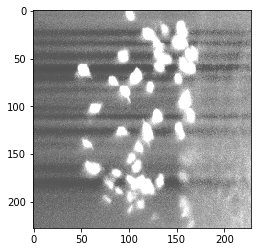

In [303]:
input_img_log = np.log(1 + input_img)

plt.imshow(input_img_log, clim=[4, 6])
plt.show()

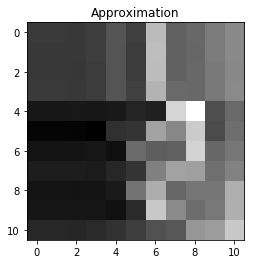

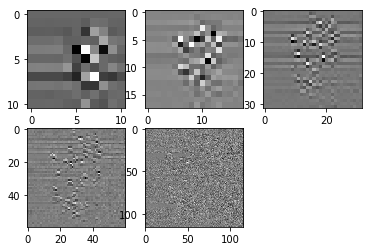

max energy on level 5: 687.2821044921875
max energy on level 4: 1093.541259765625
max energy on level 3: 543.2802734375
max energy on level 2: 80.80563354492188
max energy on level 1: 56.987060546875


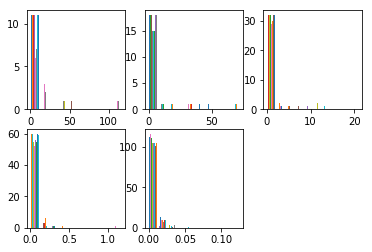

In [304]:
coeffs = pywt.wavedec2(input_img_log, wavelet)
approx = coeffs[0]
detail = coeffs[1:]

nb_levels = len(detail)

plt.title('Approximation')
plt.imshow(approx)
plt.show()

for i, (ch, cv, cd) in enumerate(detail):
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch)
plt.show()

for i, (ch, cv, cd) in enumerate(detail):
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    ch_sq = ch**2
    plt.hist(ch_sq[:])
    print(f'max energy on level {nb_levels-i}: {ch_sq.sum()}')
plt.show()

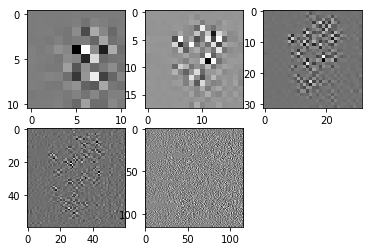

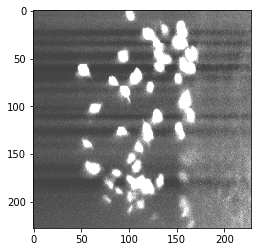

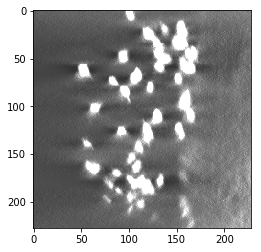

In [305]:
sigma = 64  # pixels

width_fraction = sigma / input_img_log.shape[0]

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    ch_fft = fftpack.rfft(ch, axis=-1)
    
    s = ch.shape[0] * width_fraction
    g = gaussian_filter(shape=ch_fft.shape, sigma=s)
    
    ch_filtered = fftpack.irfft(ch_fft * g)
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch_filtered)
    
    coeff_filtered.append((ch_filtered, cv, cd))

plt.show()
    
img_log_filtered = pywt.waverec2(coeff_filtered, wavelet)

img_filtered = np.exp(img_log_filtered)-1

plt.imshow(input_img, clim=[0, 400])
plt.show()

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

FFT filtering in log-space seems to produce much less ringing, which is promising. Let's try thresholding combined thresholding-FFT

# Log-space energy thresholding

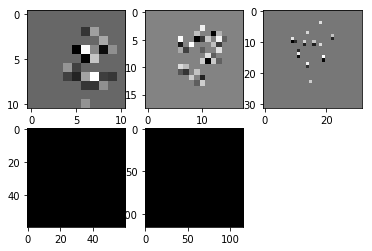

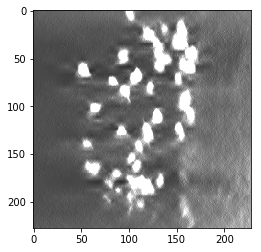

In [306]:
threshold = 5

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    mask = ch**2 > threshold
    ch_filtered = ch * mask
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(ch_filtered)
    
    coeff_filtered.append((ch_filtered, cv, cd))

plt.show()
    
img_log_filtered = pywt.waverec2(coeff_filtered, wavelet)
img_filtered = np.exp(img_log_filtered)+1

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

# Log-space thresholding-FFT filtering

1.3727112 10.803767
0.9901248 8.517459
0.43648928 4.5626526
0.09642339 1.0834645
0.049632106 0.35424542


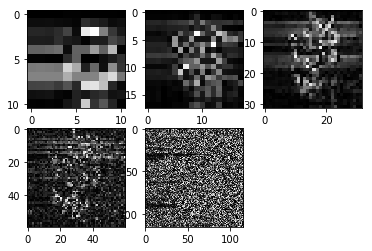

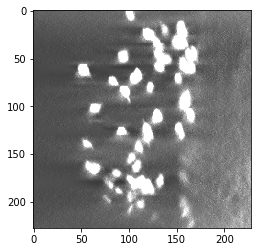

In [307]:
max_threshold = 4
sigma = 64

coeff_filtered = [approx]
for i, (ch, cv, cd) in enumerate(detail):
    ch_sq = ch**2
    ch_power = np.sqrt(ch_sq)
    print(ch_power.mean(), ch_power.max())
    
    threshold = min(max_threshold, np.sqrt(filters.threshold_otsu(ch_sq)))
#     threshold = max(0.2, np.sqrt(filters.threshold_otsu(ch_sq)))
#     threshold = max_threshold
    
    mask = ch_power > threshold
    foreground = ch * mask
    background = ch * (1-mask)
    
    background_means = np.broadcast_to(np.median(background, axis=-1)[:, np.newaxis], ch.shape)
    background_inpainted = background + background_means*mask
    
    fft = fftpack.rfft(background_inpainted, axis=-1)
    s = fft.shape[0] * width_fraction
    g = gaussian_filter(shape=fft.shape, sigma=s)
    background_filtered = fftpack.irfft(fft * g)
    
    ch_filtered = foreground + background_filtered*(1-mask)
    
    plt.subplot(2, int(np.ceil(nb_levels/2)), i+1)
    plt.imshow(np.sqrt(background_inpainted**2))
    coeff_filtered.append((ch_filtered, cv, cd))   

plt.show()
    
img_log_filtered = pywt.waverec2(coeff_filtered, wavelet)
img_filtered = np.exp(img_log_filtered)+1

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

This is probably the best filtering, but it's very difficult to set the thresholds for each level. The amount of energy that is in each level corresponding to streaks and true signal depend on the sample. Since the final result is only marginally better than the log-space FFT filtering, we just use the simpler of the two: the log-space FFT filtering. In this case, we don't need to come up with any thresholds and we still get decent streak filtering.

In Pystripe, this log-space FFT filtering of horizontal wavelet coefficients is used on the foreground and background separately (in a "dual-band" approach). This is done because the background often needs more streak filtering than the foreground, and foreground information could be corrupted if we filter it too much.

# Dual-band log-space FFT filtering

1.538828043394445e-12 0.2604172435054079 1.0


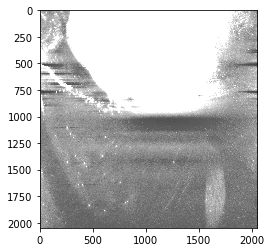

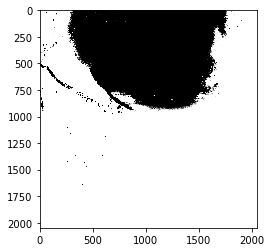

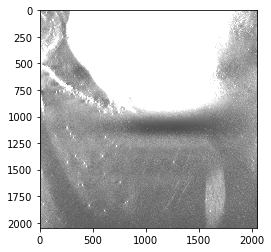

In [367]:
from scipy import ndimage


input_path = '052660.tif'
# input_path = 'crop.tif'
wavelet = 'db5'
sigma_background = 1024  # pixels
sigma_foreground = 128
threshold = 600
crossover = 20

input_img = tifffile.imread(input_path)

background = np.clip(input_img, None, threshold)
foreground = np.clip(input_img, threshold, None)

mask = input_img >= threshold

# Background filtering
background_log = np.log(1 + background)
foreground_log = np.log(1 + foreground)

background_coeffs = pywt.wavedec2(background_log, wavelet)
background_approx = background_coeffs[0]
background_detail = background_coeffs[1:]

foreground_coeffs = pywt.wavedec2(foreground_log, wavelet)
foreground_approx = foreground_coeffs[0]
foreground_detail = foreground_coeffs[1:]

nb_levels = len(background_detail)
background_frac = sigma_background / input_img.shape[0]
foreground_frac = sigma_foreground / input_img.shape[0]

background_coeff = [background_approx]
foreground_coeff = [foreground_approx]

for (bch, bcv, bcd), (fch, fcv, fcd) in zip(background_detail, foreground_detail):
    
    bch_fft = fftpack.rfft(bch)
    fch_fft = fftpack.rfft(fch)
    
    bs = bch.shape[0] * background_frac
    fs = fch.shape[0] * foreground_frac
    
    bg = gaussian_filter(shape=bch_fft.shape, sigma=bs)
    fg = gaussian_filter(shape=fch_fft.shape, sigma=fs)
    
    bch_filtered = fftpack.irfft(bch_fft * bg)
    fch_filtered = fftpack.irfft(fch_fft * fg)
    
    background_coeff.append((bch_filtered, bcv, bcd))
    foreground_coeff.append((fch_filtered, fcv, fcd))
    
background_log_filtered = pywt.waverec2(background_coeff, wavelet)
foreground_log_filtered = pywt.waverec2(foreground_coeff, wavelet)

background_filtered = np.exp(background_log_filtered)-1
foreground_filtered = np.exp(foreground_log_filtered)-1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def foreground_fraction(img, center, crossover, smoothing):
    z = (img-center)/crossover
    f = sigmoid(z)
    return f #ndimage.gaussian_filter(f, sigma=smoothing)

f = foreground_fraction(input_img.astype('float'), threshold, crossover, smoothing=1)

img_filtered = foreground_filtered * f + background_filtered * (1-f)

print(f.min(), f.mean(), f.max())

plt.imshow(input_img, clim=[0, 400])
plt.show()

plt.imshow(1-f, clim=[0, 1])
plt.show()

plt.imshow(img_filtered, clim=[0, 400])
plt.show()

Note that larger images need larger sigmas. For 2048, 1024 works well. For 256, 128 works. So similar fractions work